# AST4310, Autumn 2020, Project 4
## Authored by 15908 & 15907

In [1]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

Including necessary imports.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from astropy import units as u, constants as c
from astropy.table import QTable  # to use tables with units
from astropy.modeling.models import BlackBody  # to compute the Planck function
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats, HTML, display
from numpy import newaxis as nax  # to simplify the many uses of this
import warnings

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(7, 7 / 1.75)) # Larger figure sizes
plt.rc('font', size=12)

i_units = "kW m-2 sr-1 nm-1"  # More practical SI units

## Task 1

The falc model is a 1D model of the solar atmosphere. The model is semi-empirical, meaning that it is based on the laws of physics and adjusted according to observations. First, we will study some of the assumptions this model is based on. We start by extracting the data from this model by the following function.

In [3]:
def read_table_units(filename):
    """
    Reads a table in a text file, formatted with column names in first row,
    and unit names on second row. Any deviation from this format will fail.
    """
    tmp = np.genfromtxt(filename, names=True)
    unit_names = open(filename).readlines()[1][1:].split()
    
    # Convert to astropy QTable to have units
    data = QTable(tmp)
    
    # Assign units to quantities in table, use SI units
    for key, unit in zip(data.keys(), unit_names):
        data[key].unit = unit
        data[key] = data[key].si  # We don't want to use deprecated units
    return data

In [4]:
falc = read_table_units("falc.dat")
print(falc.keys())

['height', 'tau_500', 'colmass', 'temperature', 'v_turb', 'hydrogen_density', 'proton_density', 'electron_density', 'pressure', 'p_ratio', 'density']


In hydrostatic equilibrium total pressure has to balance gravity. For a location in the atmosphere can write this requirement as 
\begin{equation}
    \tag{1}
    \vec{F}_P = -\vec{F}_G = -M\vec{g}(\vec{r})\,,
    \label{eq:pressure}
\end{equation}
where $\vec{F}_P$ is the total pressure force, and $\vec{F}_G$ is the gravitational force exerted by the mass above. 
In the atmosphere the gravitational pull is approximately constant, and $\vec{g}(\vec{r}) \approx g$ with direction towards the interior. This is because most of the mass is located at the interior, and we are looking at a relatively short region above the surface.

We can rewrite the total pressure force as total pressure times area. $F_P = p_\textrm{tot} A$ with direction outwards from the sun. Under this reasoning, we can rewrite equation \eqref{eq:pressure} to 
$$ p_\textrm{tot} A = M g \Rightarrow p_\textrm{tot} = g \frac{M}{A}\,.$$
Here we make use of the quantity column mass, which is the mass above us at a cross section A. The mass in the falc table is expressed as column mass, at a cross section of 1 m$^2$. Denoting this column mass as lowercase $m$, we end up with
\begin{equation}
    \tag{2}
    p_\textrm{tot} = g m\,.
    \label{eq:p_tot}
\end{equation}
Because $g$ is constant in the atmosphere, we expect column mass to scale linearly with total pressure. We extract total pressure and column mass over the surface of the sun from the falc table, and plot it.

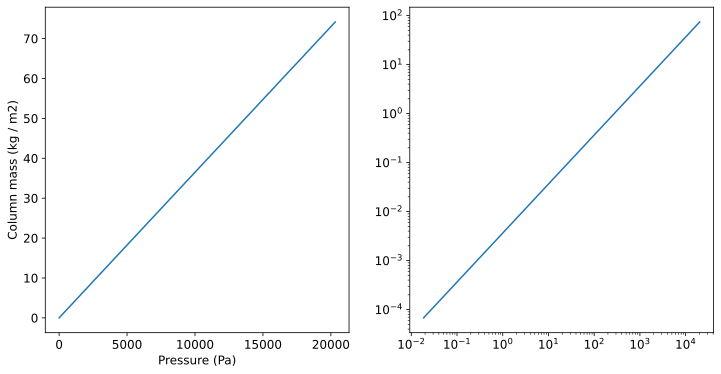

In [30]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
colmass = falc['colmass'].to("kg m-2")
pressure = falc['pressure'].to("Pa")
ax[0].plot(pressure, colmass)
ax[1].loglog(pressure.value, colmass.value);
ax[0].set_ylabel("Column mass (%s)" %colmass.unit)
ax[0].set_xlabel("Pressure (%s)" %pressure.unit);

From inspection of the data, we see that our expectations were correct. In the above plots the column mass indeed scales linearly against total pressure. Both plots have the same units along the axes. The log plot to the right emphasizes the low pressure/column mass region, and we also see the quantities scaling linearly against each other here. Thus, we can find the value of the surface gravity by taking the derivative of equation \eqref{eq:p_tot}. In the linear case we solve $g = \Delta p_\textrm{tot}/\Delta m$, which is coded by

In [6]:
g = (pressure[-1] - pressure[0])/(colmass[-1] - colmass[0])
g.decompose()

<Quantity 273.965215 m / s2>

and we see that $g \approx 274 \, \textrm{m/s}^2$.

In complete mixing, the element abundances are the same in all layers, i.e. constant with height. We check this by plotting the hydrogen mass ratio in the atmosphere, defined as
$$N_\textrm{H} = \frac{\rho_\textrm{H}}{\rho} = \frac{n_\textrm{H} m_\textrm{H}}{\rho}\,,$$
where we know the total mass density $\rho$ and the hydrogen number density $n_\textrm{H}$ from the falc table. We also plot the combined mass ratio of Hydrogen and Helium, 
$$N_\textrm{H} + N_\textrm{He} = \frac{n_\textrm{H} m_\textrm{H} + 0.1n_\textrm{H} \cdot 3.97 m_\textrm{H}}{\rho}\,.$$

Average Hydrogen mass ratio: 0.713843. Average Hydrogen + Helium mass ratio: 0.997239.


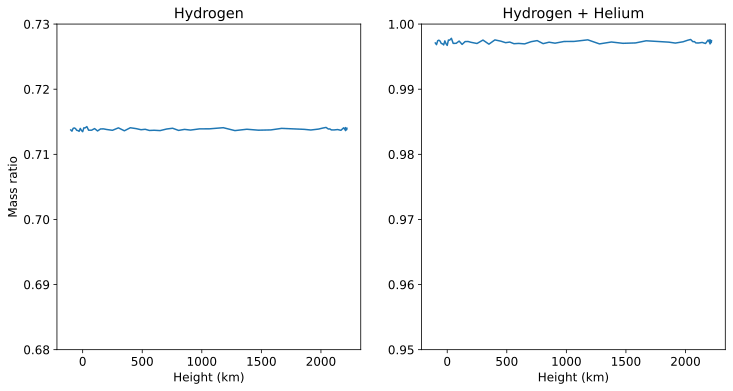

In [7]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
height = falc["height"].to("km")
hydrogen_density = falc['hydrogen_density']
density = falc['density']
H_ratio = hydrogen_density*c.m_p/density
H_He_ratio = (hydrogen_density*c.m_p + 0.1*hydrogen_density*3.97*c.m_p)/density
ax[0].plot(height, H_ratio)
ax[0].set_ylim(0.68,0.73)
ax[1].plot(height, H_He_ratio)
ax[1].set_ylim(0.95,1)
ax[0].set_title("Hydrogen")
ax[1].set_title("Hydrogen + Helium")
ax[0].set_ylabel("Mass ratio")
ax[0].set_xlabel("Height (%s)" %height.unit)
ax[1].set_xlabel("Height (%s)" %height.unit);
print("Average Hydrogen mass ratio: %.6f. Average Hydrogen + Helium mass ratio: %.6f." \
      %(np.average(H_ratio),np.average(H_He_ratio)))

From the left plot we see the Hydrogen mass ratio as a function of height. The mass ratio is approximately constant. The right plot shows the combined mass ratio of Hydrogen and Helium, which we also see is roughly constant. The mass ratio of the other elements (metals) in the atmosphere is then $1 - (N_\textrm{H} + N_\textrm{He})$, which is 

In [8]:
np.average(1 - H_He_ratio.value)

0.0027612517515900976

The fraction made up of metals is very low at only $0.2761 \%$.

The ideal gas law states that
\begin{equation}
    \tag{3}
    p_\textrm{gas} = nk_\textrm{B}T\,,
    \label{eq:ideal}
\end{equation}
where $n$ is the number density in the gas. As we have previously seen, almost the entire mass ratio is made up of Hydrogen and Helium. It may be assumed to calculate the gas pressure using only these number densities. However, this would lead to inaccuracies as we have to account for the light electron. Despite not contributing much to the mass ratio, this particle has a relevant number density. The number density for electrons is given in the falc table.

The gas pressure is calculated from the falc table by the quantities `pressure` and `p_ratio` by
$$p_\textrm{gas} = \textrm{pressure}\cdot\textrm{p_ratio}\,,$$
because `p_ratio` is the ratio between gas pressure and total pressure.

We also calculate the gas pressure using equation \eqref{eq:ideal}, and include different particles into $n$ to investigate how this alters the pressure. We try $n = n_\textrm{H}$, $n = n_\textrm{e} + n_\textrm{H}$, and $n = n_\textrm{e} + n_\textrm{H} + n_\textrm{He}$. We investigate the effects of including different terms in $n$ by plotting the gas pressure calculated from ideal gas law and gas pressure obtained from the falc table.

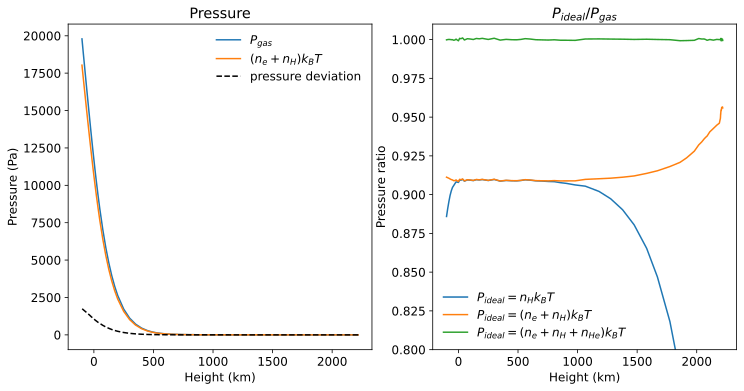

In [9]:
p_gas = pressure*falc['p_ratio']
electron_density = falc['electron_density']
temperature = falc['temperature']
p_ideal = ((hydrogen_density + electron_density)*c.k_B*temperature).to('Pa')
p_ideal_new = p_ideal + 0.1*hydrogen_density*c.k_B*temperature
p_ideal_H = hydrogen_density*c.k_B*temperature
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(height, p_gas, label=r"$P_{gas}$")
ax[0].plot(height, p_ideal, label=r"$(n_e + n_H)k_B T$")
ax[0].plot(height, p_gas - p_ideal, label=r"pressure deviation", ls='--', color='k')
ax[0].set_ylabel("Pressure (%s)" %p_gas.unit)
ax[0].set_title("Pressure")
ax[0].set_xlabel("Height (%s)" %height.unit)
ax[0].legend()
ax[1].plot(height, p_ideal_H/p_gas, label=r"$P_{ideal} = n_H k_B T$")
ax[1].plot(height, p_ideal/p_gas, label=r"$P_{ideal} = (n_e + n_H)k_B T$")
ax[1].plot(height, p_ideal_new/p_gas, label=r"$P_{ideal} = (n_e + n_H + n_{He})k_B T$")
ax[1].set_ylabel("Pressure ratio")
ax[1].set_xlabel("Height (%s)" %height.unit)
ax[1].set_title(r"$P_{ideal}/P_{gas}$")
ax[1].set_ylim(0.8, 1.01)
ax[1].legend();

In the left-most figure, we see the gas pressure from the falc table plotted alongside gas pressure calculated by equation \eqref{eq:ideal}, using $n = n_\textrm{e} + n_\textrm{H}$. There is clearly some deviation in pressure, that is more evident for low heights. We get a better view of the pressure difference in the right-most figure. Here we see the ratio between pressure calculated by equation \eqref{eq:ideal}, and gas pressure obtained from the falc table. When we include electron, hydrogen, and helium particles in $n$, we see a ratio of 1. If we don't include helium particles the ratio is just over 0.9, and climbing with height. When we remove both helium and electrons from $n$, the ratio stoops down when height passes $1000\,\textrm{km}$. 

We can find the fraction of ionized hydrogen from the falc table. The expectation is that the logarithm of this quantity should scale with temperature, because of the Saha distribution. The Saha distribution for ionized to neutral hydrogen is
\begin{equation}
    \tag{4}
    \left[ \frac{N_{II}}{N_I}\right]^\textrm{TE} N_e = \frac{2U_{II}}{U_I} \left( \frac{2\pi m_e k_\textrm{B}   
    T}{h^2}\right)^{3/2}e^{-\chi_r/k_\textrm{B}T}\,.
    \label{eq:Saha}
\end{equation}
Taking the logarithm of equation \eqref{eq:Saha} should make the fraction roughly scale with temperature. We see this by splitting up the factors according to logarithm rules.
\begin{equation}
    \tag{5}
     \log \left (\left[ \frac{N_\textrm{II}}{N_\textrm{I}}\right]^\textrm{TE}\right ) = \log \left (\frac{2U_{II}}{U_I}\right) + \log \left( \frac{1}{N_e} \left( \frac{2\pi m_e k_\textrm{B}}{h^2}\right)^{3/2} \right) + \frac{3}{2} \log T + \log \left(e^{-\chi_r/k_\textrm{B}T}\right)\,.
     \label{eq:log}
\end{equation}
Here, we can make some approximations based on our knowledge of the partition function $U$. Firstly, it does not have a strong dependence on temperature. Secondly, it mostly assumes values between $1$ and $2$. An example of this is presented in pages 52-53 of the lecture notes (INTRODUCTION TO ASTROPHYSICAL RADIATIVE TRANSFER, Robert J. Rutten). Therefore, the partition function fraction in equation \eqref{eq:log} is assumed to be constant relative to the other temperature-dependent terms.

The exponential term is a little bit more involved. However, for high temperatures it should have a weak dependence of temperature. We end up with 

\begin{equation}
    \tag{6}
    \log \left (\left[ \frac{N_\textrm{II}}{N_\textrm{I}}\right]^\textrm{TE}\right ) \approx \frac{3}{2}\log T + \textrm{const.}\,,
\end{equation}
meaning that the Saha distribution scales with temperature.

We plot the fraction of ionized hydrogen against height. For the Saha distribution, we assume the ratio between the partition functions to be 1.  We also plot the temperature against height to view the temperature dependence of the fraction of ionization.

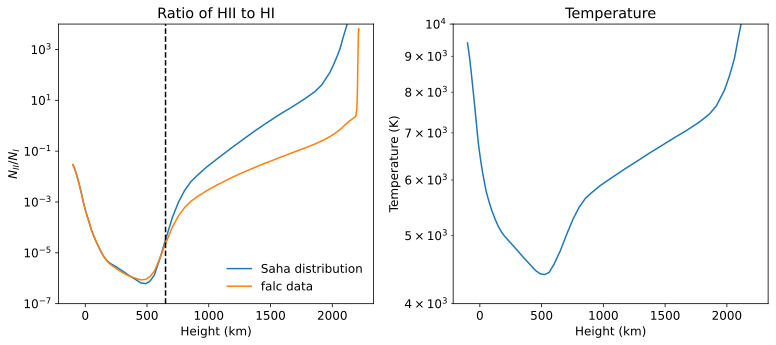

In [10]:
def Saha(T, N_e):
    return 1/N_e*(2*np.pi*c.m_e*c.k_B*T/c.h**2)**(3/2)*np.exp(-13.6*u.eV/(c.k_B*T))

proton_density = falc['proton_density']
fig,ax=plt.subplots(1,2,figsize=(11,5))
ax[1].semilogy(height, temperature.value)
ax[1].set_title("Temperature")
ax[1].set_xlabel("Height (%s)" %height.unit)
ax[1].set_ylabel("Temperature (%s)" %temperature.unit)
ax[1].set_ylim(4000, 10000)
ax[0].semilogy(height, Saha(temperature, electron_density).value, label="Saha distribution")
warnings.filterwarnings("ignore")   #Ignore divide by zero in NII/NI
ax[0].semilogy(height, proton_density/(hydrogen_density-proton_density), label="falc data")
ax[0].set_title("Ratio of HII to HI")
ax[0].set_ylabel(r"$N_{II}/N_{I}$")
ax[0].set_xlabel("Height (%s)" %height.unit)
ax[0].axvline(x=650, color='k', ls='--')
ax[0].set_ylim(1e-7,1e4)
ax[0].legend()
plt.tight_layout();

In the leftmost figure, the dashed black line indicates $650 \,\textrm{km}$. In this figure, we see that the logarithm of the Saha distribution scales with temperature. The ionization fraction from the falc data follows the Saha distribution for small heights, and thus also scales with temperature. For heights over $650 \,\textrm{km}$, we see the falc data deviating from the Saha distribution, and no longer scales with temperature. Since the assumption behind the Saha distribution is thermodynamical equilibrium, the atmosphere can not be in thermodynamical equilibrium above this height.

The photon density in thermodynamical equilibrium is 
\begin{equation}
    \tag{7}
    N_\textrm{phot} = 60.42\left( \frac{k_\textrm{B}T}{hc} \right)^3\,.
\end{equation}
This gives a reasonable approximation for the deeper locations in the model. Higher up in the atmosphere, this approximation breaks down and we calculate the photon density by
\begin{equation}
    \tag{8}
    N_\textrm{phot} = \frac{60.42}{2\pi}\left( \frac{k_\textrm{B}T_\textrm{eff}}{hc} \right)^3\,,
\end{equation}
where $T_\textrm{eff} = 5777\,\textrm{K}$. We calculate the photon density at the deepest and highest model location, and compare it to the hydrogen density accordingly:

In [11]:
T_eff = 5777*u.K
N_phot_lower = (60.42*(c.k_B*temperature/(c.h*c.c))**3)
N_phot_upper = (60.42/(2*np.pi)*(c.k_B*T_eff/(c.h*c.c))**3)
print("Photon and hydrogen density at the deepest model location: %.2e m-3 and %.2e m-3."\
      %(N_phot_lower[-1].value, hydrogen_density[-1].value))
print("Photon and hydrogen density in the upper atmosphere:       %.2e m-3 and %.2e m-3."\
      %((60.42/(2*np.pi)*(c.k_B*T_eff/(c.h*c.c))**3).value, hydrogen_density[0].value))

Photon and hydrogen density at the deepest model location: 1.68e+19 m-3 and 1.35e+23 m-3.
Photon and hydrogen density in the upper atmosphere:       6.22e+17 m-3 and 5.57e+15 m-3.


We see that the hydrogen density is higher than the photon density at the deepest model location. In the upper atmosphere, the photon density is highest. At the upper atmosphere, the hydrogen density is low and almost entirely made up of protons. 

Therefore, the medium there interacts weakly with the photons. Because all the particles there are charged (photons or electrons), the photons will be scattered and not absorbed. 

## Task 2

To study different analysis methods for a star, we can use the data set acquired by __[Allen (1976)](https://ui.adsabs.harvard.edu/abs/1976asqu.book.....A/abstract)__ to study the difference between intensity and flux per wavelength and per frequency, estimates of temperature and brightness temperature.

First we can load the dataset into a dictionary from the file solspec.dat. We use the numpy function genfromtxt to load the data into an array and place it into a dictionary. The units in the dataset are given in cgs per micrometer, but we will convert it to SI units per nanometer. The only exception is the wavelength which we keep as micrometers. We begin by plotting he measures data to visualize it. The data contains values of flux and intensity, both continuum and smoothed, for the wavelength interval $[0.2, 5] \mu$m.

In [12]:
unit = "erg s^-1 cm^-2 micrometer^-1 sr^-1"
data_2 = np.genfromtxt("solspect.dat")
data_2 = {"Wavelength": data_2[:, 0] * u.micrometer, \
          "Flux_smooth": 10 ** (10) * data_2[:, 1] \
          * u.Unit(unit).to(i_units) * u.Unit(i_units), \
          "Flux_continuum": 10 ** (10) * data_2[:, 2] \
          * u.Unit(unit).to(i_units) * u.Unit(i_units), \
          "Intensity_smooth": 10 ** (10) * data_2[:, 3] \
          * u.Unit(unit).to(i_units) * u.Unit(i_units), \
          "Intensity_continuum": 10 ** (10) * data_2[:, 4] \
          * u.Unit(unit).to(i_units) * u.Unit(i_units) \
         }

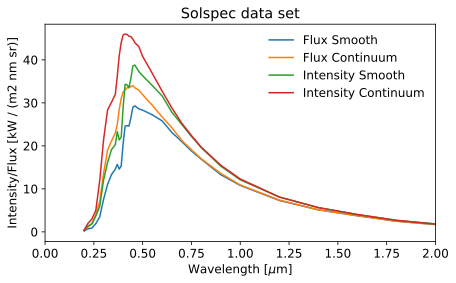

Wavelength 0.41 um at continuum intensity maximum 46.0 kW / (m2 nm sr)


In [31]:
plt.figure()
plt.plot(data_2["Wavelength"], data_2["Flux_smooth"])
plt.plot(data_2["Wavelength"], data_2["Flux_continuum"])
plt.plot(data_2["Wavelength"], data_2["Intensity_smooth"])
plt.plot(data_2["Wavelength"], data_2["Intensity_continuum"])

plt.title("Solspec data set")
plt.legend(["Flux Smooth", "Flux Continuum", "Intensity Smooth", "Intensity Continuum"])
plt.xlim(0, 2)
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel(r"Intensity/Flux [%s]"%data_2["Flux_smooth"].unit)
plt.show()

max_index = data_2["Intensity_continuum"] == np.max(data_2["Intensity_continuum"])
Intensity = data_2["Intensity_continuum"][max_index][0]
Wavelength = data_2["Wavelength"][max_index][0]
print("Wavelength", Wavelength, "at continuum intensity maximum", Intensity)

In the plot of the data we see that the continuum intensity has the largest peak at about 46.0 and that the flux has a lower peak than the intensity. We can also see that the continuum has a higher peak than the smoothed values. The intensity is the radiation passing through a cross section per star radian. We have chosen to look at the intensity per wavelength and this gives us the units along the y axis. The flux has the same units, but is a vector value. Thus, the flux is only the intensity along the normal of the cross section, not all radiation passing through. This means we have the same units, just that we would probably get an equal or lower value for all wavelengths. The smoothing is simply the process of trying to make the spectral lines less visible. This process has of course no effects on the units of the quantity.

We expect the intensity and flux to be change more slowly if we calculate the quantities per frequency instead of per wavelength. This is a result of a change in wavelength correspond to a much shorter change in frequency. We can see this is we calculate the frequency
\begin{equation}
    \tag{9}
    f_1 = \frac{c}{\lambda_1}
\end{equation}
as a function of wavelength and than increase the wavelength by some constant.
\begin{equation}
    \tag{10}
    \lambda_2 = \lambda_1 + 1 \Rightarrow f_2 = \frac{c}{\lambda_1 + 1} = f_1 \frac{\lambda_1}{\lambda_1 + 1}
\end{equation}
The increase in wavelength of $1$ results in a multiplicative increase in frequency which for wavelengths much larger than $1$ is almost equal to 1.
To check this we can use our data and calculate the quantity per frequency by multiplying each quantity with wavelength squared divided by the speed of light.

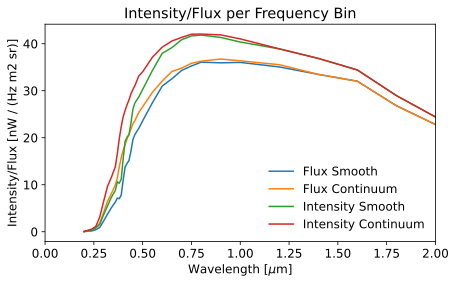

In [14]:
i_units_2 = "nW m^-2 Hz^-1 sr^-1"

inte_Fs = data_2["Flux_smooth"] * data_2["Wavelength"] ** 2 / c.c
inte_Fc = data_2["Flux_continuum"] * data_2["Wavelength"] ** 2 / c.c
inte_Is = data_2["Intensity_smooth"] * data_2["Wavelength"] ** 2 / c.c
inte_Ic = data_2["Intensity_continuum"] * data_2["Wavelength"] ** 2 / c.c

plt.figure()
plt.plot(data_2["Wavelength"], (inte_Fs.to(i_units_2)))
plt.plot(data_2["Wavelength"], (inte_Fc.to(i_units_2)))
plt.plot(data_2["Wavelength"], (inte_Is.to(i_units_2)))
plt.plot(data_2["Wavelength"], (inte_Ic.to(i_units_2)))

plt.title("Intensity/Flux per Frequency Bin")
plt.legend(["Flux Smooth", "Flux Continuum", "Intensity Smooth", "Intensity Continuum"])
plt.xlim(0, 2)
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel(r"Intensity/Flux [%s]"%inte_Fs.to(i_units_2).unit)

plt.show()

The flux and intensity per frequency as functions of wavelength peak at a larger wavelength, but around the same value and gradually decrease instead of the very sudden drop when dependent on wavelength, just like we expected.

Finding an approximation to temperature is very useful, since we can't measure this quantity ourselves. One way to do this is to try to  fit a Planck function to the intensity continuum data. Since temperature derivative of the sum of the Planck function for all wavelength is always positive, we can simply use the absolute value of the difference between the sum of the intensity continuum and the sum of the Planck function as a measure of the estimate error of our model and find the minimum value for this method. The temperature which gives the least error is the closest to the actual temperature.

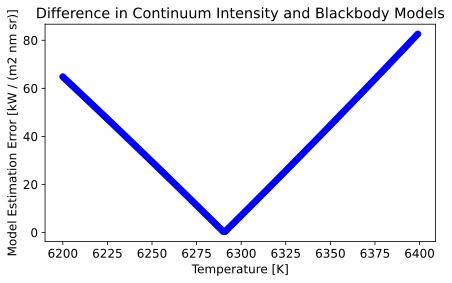

Temp at minimum intensity 6290.909090909091 K


In [15]:
from astropy.modeling.models import BlackBody

sc = 1 * u.Unit(i_units)
tot_int = np.sum(data_2["Intensity_continuum"])

liste = np.zeros(1)

plt.figure()
for i in range(6200, 6400, 1):
    MEE = np.abs(tot_int - np.sum(BlackBody(i * u.K, scale = sc)(data_2["Wavelength"])))
    liste = np.append(liste, float(MEE.value))
    plt.plot(i * u.K, MEE, "bo")

plt.title("Difference in Continuum Intensity and Blackbody Models")
plt.xlabel("Temperature [K]")
plt.ylabel("Model Estimation Error [%s]"%MEE.unit)
plt.show()

liste = liste[1:-1]
min_int = np.linspace(6200, 6400, 199)[liste == liste.min()][0] * u.K

print("Temp at minimum intensity", min_int)

From this calculation we can see that we obtain the best model with a temperature of approximately 6290 kelvin. We can visualize the to check that it is indeed close to the data set values.

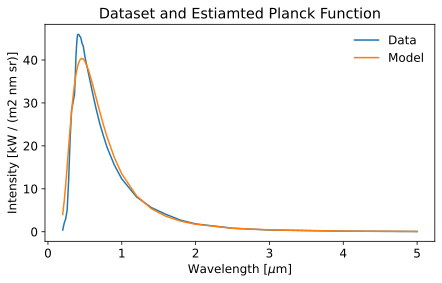

In [16]:
plt.figure()
plt.plot(data_2["Wavelength"], data_2["Intensity_continuum"])
plt.plot(data_2["Wavelength"], BlackBody(min_int, scale = sc)(data_2["Wavelength"]))

plt.title("Dataset and Estiamted Planck Function")
plt.legend(["Data", "Model"])
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel(r"Intensity [%s]"%data_2["Flux_smooth"].unit)
plt.show()

The Planck function follows the data set very closely, except for around the peak, where it stops around 6kWm$^{-2}$nm$^{-1}$sr$^{-1}$ before the data. This deviation might be a result of the data set varying in what layer of the Sun it is from. 

We can however also calculate the brightness temperature, as a result of the intensity, at different wavelengths. This is useful, since it gives us an idea of how the temperature might vary with wavelength. If we only calculated data over a single time instant and also a single layer and area of the sun, we would expect the brightness temperature to be constant for all wavelengths, and to follow a Planck function. Whoever, since we now this is the case we expect there to be some variation.

The brightness temperature is found by rewriting the Planck function
\begin{equation}
    \tag{11}
    B(T) = \frac{2 h c^2}{\lambda^5} \frac{1}{e^{\frac{hc}{\lambda k T}} - 1}
\end{equation}
into temperature and using the measured intensity as values of $B(T)$
\begin{equation}
    \tag{12}
    T = \frac{h c}{\lambda k \ln \left( \frac{2 h c^2}{\lambda^5 B(T)} + 1 \right)}
\end{equation}

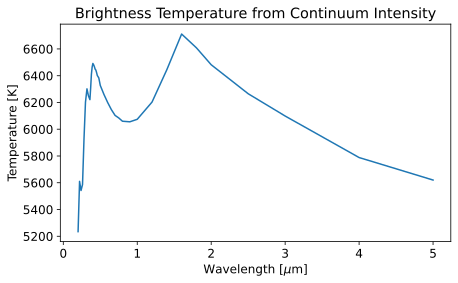

Wavelength 1.6 um at temperature maximum 6711.388150994749 K


In [17]:
def T_B(lam, B):
    top = c.h * c.c
    bottom = lam * c.k_B * np.log((2 * c.h * c.c ** 2 / (lam ** 5 * B)).si.value + 1)
    return (top / bottom).si

Temperature = T_B(data_2["Wavelength"], data_2["Intensity_continuum"])

plt.figure()
plt.plot(data_2["Wavelength"], Temperature)
plt.title("Brightness Temperature from Continuum Intensity")
plt.xlabel("Wavelength [$\mu$m]")
plt.ylabel("Temperature [K]")
plt.show()

max_index = Temperature == np.max(Temperature)
max_temp = Temperature[max_index][0]
max_wave = data_2["Wavelength"][max_index][0]
print("Wavelength", max_wave, "at temperature maximum", max_temp)

We can see a high variation in temperature, and that the variation stabilizes for higher wavelengths. Around the peak in the continuum intensity plot we see a drop in the temperature. This drop around the peak might indicate a medium which can absorb the light at around 1 micrometer in wavelength, since the brightness temperature based on the expected temperature as a result of the intensity emitted. Thus we can't really use the brightness temperature since this varies for every wavelength, but the fitted Planck function might be a good approximation.

## Task 3

A major provider for photon extinction in the sun is the H$^-$ ion. A neutral hydrogen atom can capture an additional electron to receive a net negative charge. The H$^-$ ion can extinct photons in two ways. The bound-free (bf) process where a photon ionizes H$^-$ to H, or the free-free (ff) process where a photon accelerates a free electron in the vicinity of the H$^-$ ion. The latter is called inverse bremsstrahlung. The ionization limit for H$^-$ is $0.75 \, \textrm{eV}$, or $1650 \, \textrm{nm}$. We calculate the cross section for H$^-$ extinction in the function compute_hminus_cross_section. This is a function of photon wavelength, temperature and free electron density.

In [21]:
def compute_hminus_cross_section(wavelength, temperature, electron_density):
    """
    Computes the H minus extinction cross section, both free-free and
    bound-free as per Gray (1992).
    
    Parameters
    ----------
    wavelength : astropy.units.quantity (array)
        Wavelength(s) to calculate in units of length.
    temperature: astropy.units.quantity (scalar or array)
        Gas temperature in units of K or equivalent.
    electron_density: astropy.units.quantity (scalar or array)
        Electron density in units of per cubic length.
        
    Returns
    -------
    extinction : astropy.units.quantity (scalar or array)
        Total H- extinction in si units. 
        Shape: shape of temperature + (nwave,)
    """
    # Broadcast to allow function of temperature and wavelength
    temp = temperature[..., nax]
    wave = wavelength[nax]
    theta = 5040 * u.K / temp
    electron_pressure = electron_density[..., nax] * c.k_B * temp
    # Compute bound-free opacity for H-, following Gray 8.11-8.12
    sigma_coeff = np.array([2.78701e-23, -1.39568e-18,  3.23992e-14, -4.40524e-10,
                               2.64243e-06, -1.18267e-05,  1.99654e+00])
    sigma_bf = np.polyval(sigma_coeff, wave.to_value('AA'))
    sigma_bf = sigma_bf * 1.e-22 * u.m ** 2
    # Set to zero above the H- ionisation limit at 1644.4 nm
    sigma_bf[wave > 1644.2 * u.nm] = 0.
    # convert into bound-free per neutral H atom assuming Saha,  Gray p156
    k_const = 4.158E-10 * u.cm ** 2 / u.dyn
    gray_saha = k_const * electron_pressure.cgs * theta ** 2.5 * 10. ** (0.754 * theta)
    kappa_bf = sigma_bf * gray_saha                    # per neutral H atom
    # correct for stimulated emission
    kappa_bf *= (1 - np.exp(-c.h * c.c / (wave * c.k_B * temp))) 

    # Now compute free-free opacity, following Gray 8.13
    # coefficients for 4th degree polynomials in the log of wavelength (in AA)
    coeffs = np.array([[-0.0533464, 0.76661, -1.685, -2.2763],
                          [-0.142631, 1.99381, -9.2846, 15.2827],
                          [-0.625151, 10.6913, -67.9775, 190.266, -197.789]])
    log_wave = np.log10(wave.to_value('AA'))
    log_theta = np.log10(theta.value)
    tmp = 0
    for i in range(3):
        tmp += np.polyval(coeffs[i], log_wave) * (log_theta ** i)
    kappa_ff = electron_pressure * (10 ** tmp) 
    kappa_ff = kappa_ff * 1e-26 * (u.cm ** 4) / u.dyn
    return (kappa_bf + kappa_ff).si

To get the extinction of photons per meter in the medium we are looking at, we have to multiply the cross section with the number density of neutral hydrogen atoms. We compute the extinction per meter for a range of wavelengths $\lambda \in [300, 2000]\,\textrm{nm}$ at the surface of the sun (height = 0 in the falc table).

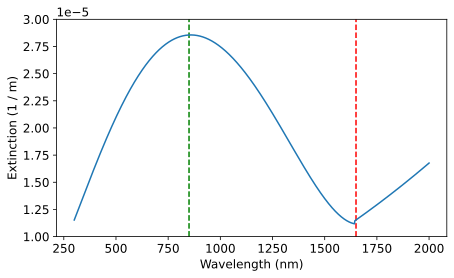

In [32]:
waves = np.linspace(300,2000,1000)*u.nm
h0 = np.where(height==0)
H_minus_ext = compute_hminus_cross_section(waves, temperature[h0], electron_density[h0])*\
    (hydrogen_density[h0]-proton_density[h0])
fig,ax = plt.subplots()
ax.set_xlabel("Wavelength (%s)" %waves.unit)
ax.set_ylabel("Extinction (%s)" %H_minus_ext.unit)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.axvline(x=1650, color='r', ls='--')
ax.axvline(x=850, color='g', ls='--')
ax.set_ylim(1e-5, 3e-5)
ax.plot(waves, H_minus_ext.ravel());

Here we see the extinction per meter from the H$^-$ bf and ff processes. The dashed red line marks the ionization limit of H$^-$ at $1650 \,\textrm{nm}$. Photons with wavelengths larger than this does not have enough energy to ionize H$^-$, and only the free-free process extincts these photons. For high energy photons, i.e. small wavelength, the probability for extinction is very low. We can see this from the graph going to zero for small wavelengths. The extinction has a maximum at $850 \, \textrm{nm}$, marked by the dashed green line. This graph does not have a maximum extinction at the ionization limit and decay $\sim \lambda^3$ for smaller wavelengths as hydrogenic atoms. This is because H$^-$ is not a hydrogenic atom although it is a form of hydrogen. Hydrogenic atoms only possess one electron, like neutral hydrogen, single ionized Helium, or Li$^{2+}$. H$^-$ has two electrons, and is consequently not hydrogenic.

In thermodynamic equilibrium, the intensity should be proportional to the source function, and the source function should be proportional to the inverse absorption. Since absorption and extinction is the same, we assume that $$ I_\lambda \propto \frac{1}{\alpha_\lambda^c}\,, $$ where $\alpha_\lambda^c$ is the continuous extinction per meter. We plot the intensity accordingly.

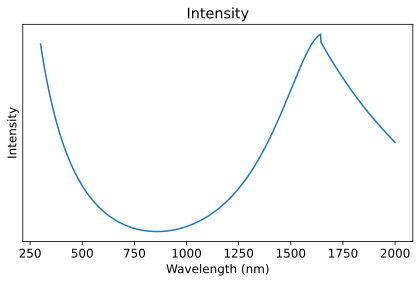

In [24]:
I_scaled = (1/H_minus_ext).value*u.W*u.m**(-2)*u.nm**(-1)
fig,ax = plt.subplots()
ax.set_xlabel("Wavelength (%s)" %waves.unit)
ax.set_ylabel("Intensity")
ax.plot(waves, (I_scaled/I_scaled.max()).flatten())
ax.set_title("Intensity")
ax.set_yticks([]);

We see that the intensity look like the solar intensity from exercise 2 in the range $\lambda \in [0.25, 2]\,\mu\textrm{m}$. This is because the continuous extinction at the wavelengths we are looking at comes mainly from H$^-$. We can then find the brightness temperature up to some scaling factor as $$ T_B = \frac{hc}{k_\textrm{B} \lambda}\ln^{-1} \left(1 + \frac{2hc^2}{I \lambda^5}\right)\,. $$ We compare this result to the brightness temperature of a black body with the same surface temperature as the falc data, which is $6520 \, \textrm{K}$. We calculate $T_B$ and plot it as a function of wavelength accordingly.

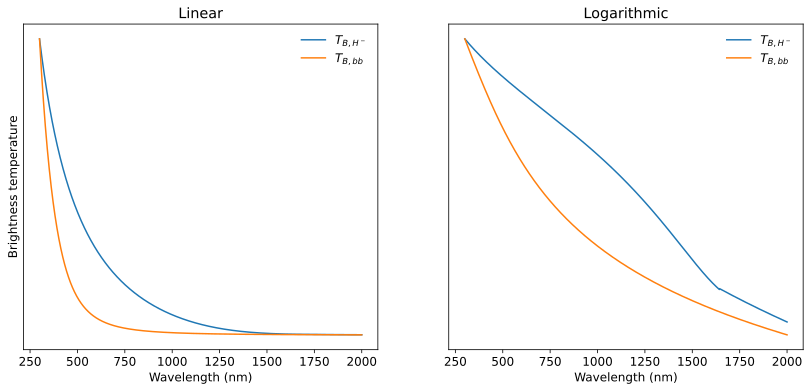

In [27]:
from astropy.modeling.blackbody import blackbody_lambda
def T_B(I, wavelength):
    return c.h*c.c/(c.k_B*wavelength)\
        *np.log(1 + 2*c.h*c.c**2/(I*wavelength**5))
T_B_scaled = T_B(I_scaled, waves).decompose().ravel()
T_B_sun = T_B(blackbody_lambda(waves, temperature[h0]).value*u.W*u.m**(-2)*u.nm**(-1), waves)
fig,ax = plt.subplots(1,2,figsize=(14,6))
ax[0].set_xlabel("Wavelength (%s)" %waves.unit)
ax[0].set_ylabel("Brightness temperature")
ax[0].plot(waves, T_B_scaled/T_B_scaled.max(), label=r"$T_{B,H^-}$")
ax[0].plot(waves, T_B_sun/T_B_sun.max(), label=r"$T_{B,bb}$")
ax[0].set_title("Linear")
ax[1].plot(waves, np.log10(T_B_scaled/T_B_scaled.max()), label=r"$T_{B,H^-}$")
ax[1].plot(waves, np.log10(T_B_sun/T_B_sun.max()), label=r"$T_{B,bb}$")
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[1].set_title("Logarithmic")
ax[1].legend(); ax[0].legend()
ax[1].set_xlabel("Wavelength (%s)" %waves.unit);

Here we see scaled brightness temperature plotted against wavelength for a black body (bb) and for the source function given by H$^-$ extinction. In the linear plot we see the two brightness temperatures resembling each other. Both functions decline for increasing wavelength, in a seemingly uniform manner. However, when we log plot brightness temperature we see different trends. The brightness temperature for H$^-$ extinction does not decline uniformly, and we can clearly see the ionization limit at $1650 \, \textrm{nm}$ affecting $T_B$.

We can also calculate the H$^-$ extinction as a function of height at a specific wavelength. Using data from the falc table, we calculate H$^-$ extinction at $\lambda = 0.5 \, \mu\textrm{m}$. We wish to compare this with Thomson scattering, which is found by
\begin{equation}
    \tag{13}
   \alpha^T = n_e \sigma^T\,,
\end{equation}
where $n_e$ is the free electron density and $\sigma^T = 6.652 \cdot 10^{-29} \, \textrm{m}^2$ is the Thompson cross section. This extinction is independent of wavelength.

We compare these two processes by plotting them together. The extinctions vary over a very large range, so we have to plot the $y$-axis logarithmically.

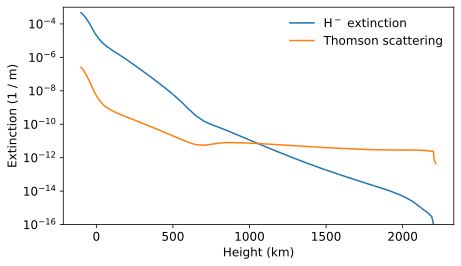

In [29]:
lambda_0 = 0.5*u.um
H_minus_falc = compute_hminus_cross_section(lambda_0, temperature, electron_density).ravel()*\
    (hydrogen_density-proton_density)
thomson_ext = 6.652e-29*u.m**2*electron_density
fig,ax = plt.subplots()
ax.set_xlabel("Height (%s)" %height.unit)
ax.set_ylabel("Extinction (%s)" %H_minus_falc.unit)
ax.semilogy(height, H_minus_falc,label=r"H$^-$ extinction")
ax.semilogy(height, thomson_ext,label="Thomson scattering")
ax.set_ylim(1e-16, 1e-3)
ax.legend();

We see that the H$^-$ extinction dominates on the surface and the inner layers of the atmosphere. As the neutral hydrogen density drops in the outer atmosphere, the H$^-$ extinction goes to zero. Since the electron density almost stays constant in the outer atmosphere, so does the Thomson extinction from $500$ to $2000 \,\textrm{km}$. Therefore the Thomson scattering dominates in the outer atmosphere.